In [7]:
columns = [
    'age', 'job', 'marital', 'education', 'balance', 'housing', 
    'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 
    'previous', 'poutcome', 'y'
]

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv('E:\\HCL_Technical_Lead\\SIE_OSIV_HCL_TRAINING\\PYTHON_DS_DE\\Machine_learning_zoomcamp_DATAtalks\\WEEK-4-EVALUATION\\data\\bank-full.csv', sep=';')


In [8]:

# Filter out necessary columns
df = df[columns]

# Split the dataset into train, validation, and test sets
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

# Reset index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Separate target variable
y_train = df_train['y'].map({'yes': 1, 'no': 0})
y_val = df_val['y'].map({'yes': 1, 'no': 0})
y_test = df_test['y'].map({'yes': 1, 'no': 0})


In [11]:
df_train_full

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
22468,52,management,married,tertiary,0,no,cellular,22,aug,232,2,-1,0,unknown,no
6896,50,admin.,single,secondary,330,yes,unknown,28,may,24,1,-1,0,unknown,no
28408,45,blue-collar,married,primary,300,yes,cellular,29,jan,203,1,261,3,failure,no
8481,38,technician,married,secondary,27,yes,unknown,3,jun,404,4,-1,0,unknown,no
28753,31,services,single,secondary,887,no,cellular,30,jan,427,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43723,50,technician,married,tertiary,1830,no,cellular,14,may,318,3,-1,0,unknown,no
32511,34,management,divorced,tertiary,528,yes,cellular,17,apr,233,2,-1,0,unknown,no
5192,48,management,married,tertiary,4191,no,unknown,21,may,363,6,-1,0,unknown,no
12172,45,admin.,married,unknown,1783,no,unknown,20,jun,11,11,-1,0,unknown,no


In [24]:
from sklearn.metrics import roc_auc_score

# Define numerical variables
numerical_vars = ['balance', 'day', 'duration', 'previous']
auc_scores = {}

for var in numerical_vars:
    score = df_train[var]
    auc = roc_auc_score(df_train['y'].map({'yes': 1, 'no': 0}), score)
    if auc < 0.5:
        auc_scores[var] = 1 - auc  # Invert if AUC < 0.5
    else:
        auc_scores[var] = auc

# Find the variable with the highest AUC
highest_auc_var = max(auc_scores, key=auc_scores.get)
highest_auc_score = auc_scores[highest_auc_var]

highest_auc_score
highest_auc_var
auc_scores

{'balance': 0.5888313805382317,
 'day': 0.525957882383908,
 'duration': 0.8147002759670778,
 'previous': 0.5985653242764153}

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer

# One-hot encoding
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(df_train.drop(columns='y').to_dict(orient='records'))
y_train = df_train['y'].map({'yes': 1, 'no': 0})

# Train the logistic regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# Validate the model
X_val = dv.transform(df_val.drop(columns='y').to_dict(orient='records'))
y_val = df_val['y'].map({'yes': 1, 'no': 0})
y_val_pred = model.predict_proba(X_val)[:, 1]

# Calculate AUC
auc_val = roc_auc_score(y_val, y_val_pred)
auc_val

0.9003324959598795

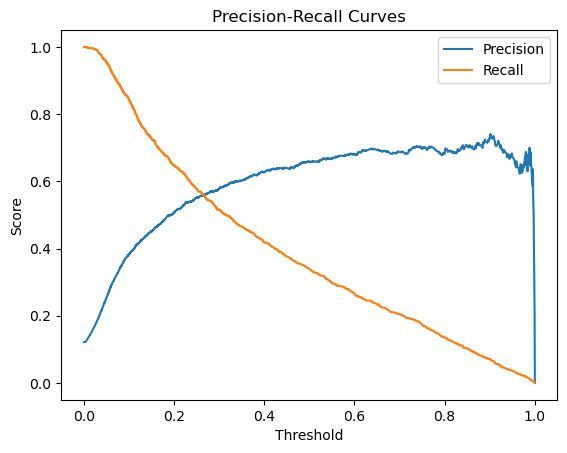

Precision and recall intersect at threshold: 0.260


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Compute precision and recall for different thresholds
precisions, recalls, thresholds = precision_recall_curve(y_val, y_pred)

# Plot precision and recall
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Curves')
plt.legend()
plt.show()

# Find the threshold where precision and recall intersect
for p, r, t in zip(precisions, recalls, thresholds):
    if np.isclose(p, r, atol=0.01):
        print(f'Precision and recall intersect at threshold: {t:.3f}')
        break


In [18]:
from sklearn.metrics import f1_score

best_f1 = 0
best_threshold = 0

for threshold in np.arange(0.0, 1.01, 0.01):
    y_pred_bin = (y_pred >= threshold).astype(int)
    f1 = f1_score(y_val, y_pred_bin)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f'Max F1 score: {best_f1:.3f} at threshold: {best_threshold:.3f}')


Max F1 score: 0.573 at threshold: 0.220


In [19]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kfold.split(df_train_full):
    df_train_kf = df_train_full.iloc[train_idx]
    df_val_kf = df_train_full.iloc[val_idx]
    
    y_train_kf = df_train_kf['y'].map({'yes': 1, 'no': 0})
    y_val_kf = df_val_kf['y'].map({'yes': 1, 'no': 0})
    
    train_dict_kf = df_train_kf[categorical + numerical].to_dict(orient='records')
    val_dict_kf = df_val_kf[categorical + numerical].to_dict(orient='records')
    
    X_train_kf = dv.fit_transform(train_dict_kf)
    X_val_kf = dv.transform(val_dict_kf)
    
    model_kf = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model_kf.fit(X_train_kf, y_train_kf)
    
    y_pred_kf = model_kf.predict_proba(X_val_kf)[:, 1]
    auc_kf = roc_auc_score(y_val_kf, y_pred_kf)
    scores.append(auc_kf)

print(f'Scores: {scores}')
print(f'Standard deviation of scores: {np.std(scores):.3f}')


Scores: [0.8993883806356288, 0.8989055268937651, 0.9112102229960733, 0.9080952264469403, 0.9100912737695956]
Standard deviation of scores: 0.005


In [30]:
C_values = [0.000001, 0.001, 1]
results = {}

for C in C_values:
    auc_scores = []
    for train_index, val_index in kfold.split(df):
        df_train_fold = df.iloc[train_index]
        df_val_fold = df.iloc[val_index]

        X_train_fold = dv.fit_transform(df_train_fold.drop(columns='y').to_dict(orient='records'))
        y_train_fold = df_train_fold['y'].map({'yes': 1, 'no': 0})

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train_fold, y_train_fold)

        X_val_fold = dv.transform(df_val_fold.drop(columns='y').to_dict(orient='records'))
        y_val_fold = df_val_fold['y'].map({'yes': 1, 'no': 0})
        y_val_fold_pred = model.predict_proba(X_val_fold)[:, 1]

        auc_score = roc_auc_score(y_val_fold, y_val_fold_pred)
        auc_scores.append(auc_score)

    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)
    results[C] = (mean_auc, std_auc)

# Find the best C value
best_C = min(results, key=lambda x: (-results[x][0], results[x][1], x))


In [31]:
best_C

1